In [2]:
%load_ext autoreload
%autoreload 2

This doc records and plots statistics for the Mimi-CXR (Mimic) and PadChest datasets including view type, pathology frequency, and also frequency of collision over select pathologies.

In [3]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import ast
import torchxrayvision as xrv

In [5]:
#Load padchest data
d_pad = xrv.datasets.PC_Dataset(imgpath="/", views=["PA","AP"])

In [7]:
#Getting Included Pathologies
#Using this dict to filter label strings

totals = d_pad.totals()
pathologies = []
for p in totals:
    pathologies.append(p)

pathologies.append('normal')

Text(0.5, 1.0, 'Gender Distribution Across Dataset')

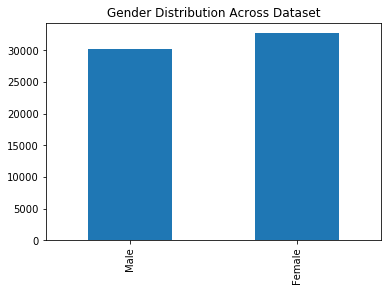

In [9]:

#Plot of total gender distribution
d_genders = pd.concat([d_pad.csv['sex_male'], d_pad.csv['sex_female']], axis=1)
d_genders = d_genders.rename(columns={"sex_male": "Male", "sex_female": "Female"})
genders_sum = d_genders.sum()
genders_sum

gender_plot = genders_sum.plot(kind="bar")
gender_plot.set_title("Gender Distribution Across Dataset")


In [10]:
#Seperate Collumns we want
d_labelData = pd.concat([d_pad.csv["Labels"], d_pad.csv["sex_male"], d_pad.csv["Projection"]], axis=1)

#Seperate out the bundled inner arrays 
d_labelData["Labels"] = d_labelData["Labels"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#Copying here for singleLabel (Seperated Labels)
d_singleLabel = d_labelData 

#Dataframe for getting single label stats later Actual single labels
d_newSingle = d_labelData[d_labelData["Labels"].apply(len) <= 1]

#Explode the collumn
d_labelData = d_labelData.explode("Labels")

#Filter out labels which aren't included in pathologies
d_labelData = d_labelData[d_labelData["Labels"].apply(lambda x: any(label.lower() == x.lower() for label in pathologies))]

d_labelData['Labels'].value_counts()

normal                         25609
cardiomegaly                    5351
aortic elongation               4562
scoliosis                       3784
costophrenic angle blunting     2044
air trapping                    1990
aortic atheromatosis            1305
pneumonia                       1075
nodule                          1070
bronchiectasis                   845
hemidiaphragm elevation          838
hilar enlargement                602
atelectasis                      577
consolidation                    448
emphysema                        306
granuloma                        298
flattened diaphragm              167
pneumothorax                      84
tuberculosis                      52
mass                              19
fracture                           7
Name: Labels, dtype: int64

In [11]:
#Class Label counts for lone labels
#Only lone labels in this dataframe
print("Normal")
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'normal' in x)]["Labels"].count())
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'normal' in x)]["Projection"].value_counts())
print("Penumonia")
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'pneumonia' in x)]["Labels"].count())
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'pneumonia' in x)]["Projection"].value_counts())
print("Cardiomegaly")
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'cardiomegaly' in x)]["Labels"].count())
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'cardiomegaly' in x)]["Projection"].value_counts())
print("Effusion")
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'pleural effusion' in x)]["Labels"].count())
print(d_newSingle[d_newSingle["Labels"].apply(lambda x: 'effusion' in x)]["Projection"].value_counts())

Normal
25609
PA    25318
AP      291
Name: Projection, dtype: int64
Penumonia
206
PA    193
AP     13
Name: Projection, dtype: int64
Cardiomegaly
670
PA    654
AP     16
Name: Projection, dtype: int64
Effusion
167
Series([], Name: Projection, dtype: int64)


In [12]:
#Class counts for multi labeled

d_pad_pnu_and_card_eff = d_singleLabel[d_singleLabel["Labels"].apply(lambda x: ('pneumonia' in x) and ('cardiomegaly' in x) and ('pleural effusion' in x))]
d_pad_pnu_and_card = d_singleLabel[d_singleLabel["Labels"].apply(lambda x: ('pneumonia' in x) and ('cardiomegaly' in x))]
d_pad_pnu = d_singleLabel[d_singleLabel["Labels"].apply(lambda x: ('pneumonia' in x))] 
d_pad_card = d_singleLabel[d_singleLabel["Labels"].apply(lambda x: ('cardiomegaly' in x))]
d_pad_eff = d_singleLabel[d_singleLabel["Labels"].apply(lambda x: ('pleural effusion' in x))]
d_pad_normal = d_singleLabel[d_singleLabel["Labels"].apply(lambda x: ('normal' in x))]


#Remove overlapping entries (including Effusion)
d_pad_pnu_1 = d_pad_pnu[~d_pad_pnu.isin(d_pad_pnu_and_card_eff)]
d_pad_card_1 = d_pad_card[~d_pad_card.isin(d_pad_pnu_and_card_eff)]
d_pad_eff = d_pad_eff[~d_pad_eff.isin(d_pad_pnu_and_card_eff)]

#Remove overlapping entries (exclusing Effusion)
d_pad_pnu_2 = d_pad_pnu[~d_pad_pnu.isin(d_pad_pnu_and_card)]
d_pad_card_2 = d_pad_card[~d_pad_card.isin(d_pad_pnu_and_card)]


print("With Effusion")
print("Normal")
print(d_pad_normal['Labels'].count())
print(d_pad_normal['Projection'].value_counts())
print("Effie")
print(d_pad_eff['Labels'].count())
print(d_pad_eff['Projection'].value_counts())
print("Cardiomegaly")
print(d_pad_card_1['Labels'].count())
print(d_pad_card_1['Projection'].value_counts())
print("Pneumonia")
print(d_pad_pnu_1['Labels'].count())
print(d_pad_pnu_1['Projection'].value_counts())
print("Overlap")
print(d_pad_pnu_and_card_eff['Labels'].count())
print(d_pad_pnu_and_card_eff['Projection'].value_counts())

With Effusion
Normal
25609
PA    25318
AP      291
Name: Projection, dtype: int64
Effie
1266
PA    1144
AP     122
Name: Projection, dtype: int64
Cardiomegaly
5336
PA    5142
AP     194
Name: Projection, dtype: int64
Pneumonia
1060
PA    1001
AP      59
Name: Projection, dtype: int64
Overlap
15
PA    14
AP     1
Name: Projection, dtype: int64


In [13]:
#Output excluding effusion

print("Cardiomegaly")
print(d_pad_card_2['Labels'].count())
print(d_pad_card_2['Projection'].value_counts())
print("Pneumonia")
print(d_pad_pnu_2['Labels'].count())
print(d_pad_pnu_2['Projection'].value_counts())
print("Overlap")
print(d_pad_pnu_and_card['Labels'].count())
print(d_pad_pnu_and_card['Projection'].value_counts())

Without
Cardiomegaly
5259
PA    5077
AP     182
Name: Projection, dtype: int64
Pneumonia
983
PA    936
AP     47
Name: Projection, dtype: int64
Overlap
92
PA    79
AP    13
Name: Projection, dtype: int64


Text(0.5, 1.0, 'Label Counts (Mutually Exclusive)')

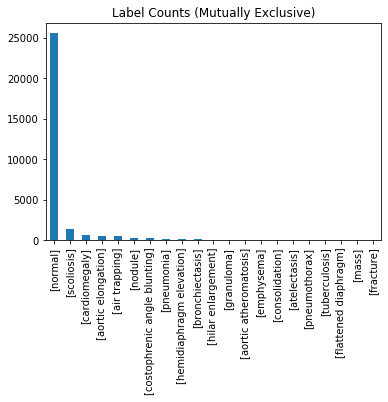

In [15]:
#Remove any with two labels remaining
d_singleLabel = d_singleLabel[d_singleLabel["Labels"].apply(lambda x: len(x) < 2)]

#Plot counts of lone label
d_singleLabel_cnts = d_singleLabel["Labels"]
d_singleLabel_cnts = d_singleLabel_cnts.value_counts()
d_singleLabel_cnts_plot = d_singleLabel_cnts.plot(kind="bar")
d_singleLabel_cnts_plot.set_title("Label Counts (Lone Label)")

Text(0.5, 1.0, 'Number of Labelings (Any Occurance)')

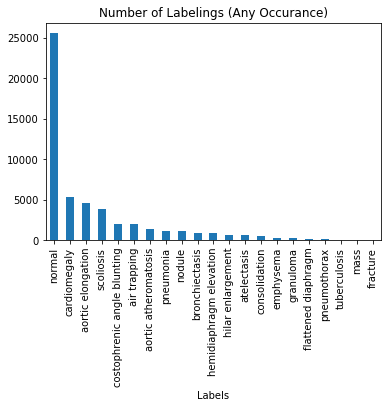

In [16]:
#Group by each label
label_counts = d_labelData.groupby(["Labels"]).size()
label_counts = label_counts.sort_values(ascending=False)

#Plot
label_counts_plot = label_counts.plot(kind="bar")
label_counts_plot.set_title("Number of Labelings (Any Occurance)")


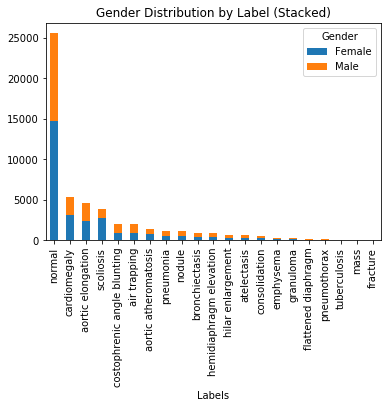

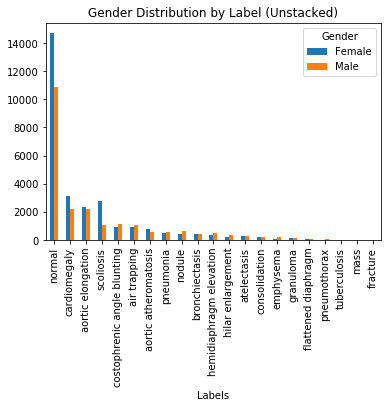

In [17]:

#Group by label, sex_male
gender_counts = d_labelData.groupby(["Labels", "sex_male"]).size().unstack(fill_value=0)

#Build sum collumn for sorting 
gender_counts['sums'] = gender_counts[True] + gender_counts[False]
gender_counts = gender_counts.sort_values(by=['sums'], ascending= False)

#Drop so it's not plotted
gender_counts = gender_counts.drop('sums', axis=1)

gender_stacked_plot = gender_counts.plot(kind="bar", stacked=True)
gender_unstacked_plot = gender_counts.plot(kind="bar", stacked=False)

gender_stacked_plot.set_title("Gender Distribution by Label (Stacked)")
gender_unstacked_plot.set_title("Gender Distribution by Label (Unstacked)")

gender_stacked_plot.legend(['Female', 'Male'], title='Gender')
gender_unstacked_plot.legend(['Female', 'Male'], title='Gender')
    

Text(0.5, 1.0, 'Views by Label')

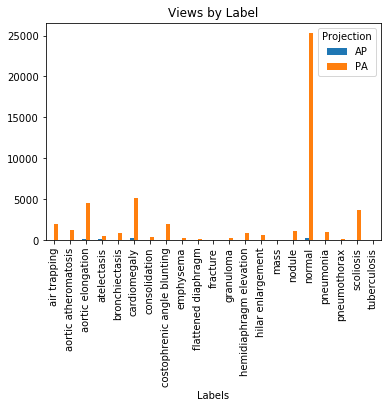

In [18]:
#Group data by which view was used
view_counts = d_labelData.groupby(["Labels", "Projection"]).size().unstack(fill_value=0)
views_plot = view_counts.plot(kind="bar")
views_plot.set_title("Views by Label")


In [19]:
#Load mimic data
#CSV Paths
metadata_path = "/ssd/jpmokc/datasets/physionet.org/files/mimic-cxr/mimic-cxr-2.0.0-metadata.csv.gz"
cheXpert_path = "/ssd/jpmokc/datasets/physionet.org/files/mimic-cxr/mimic-cxr-2.0.0-chexpert.csv.gz"

d_mimic = xrv.datasets.MIMIC_Dataset(imgpath="/", csvpath=cheXpert_path, metacsvpath=metadata_path, views=['PA','AP'])


Text(0.5, 1.0, 'View Types')

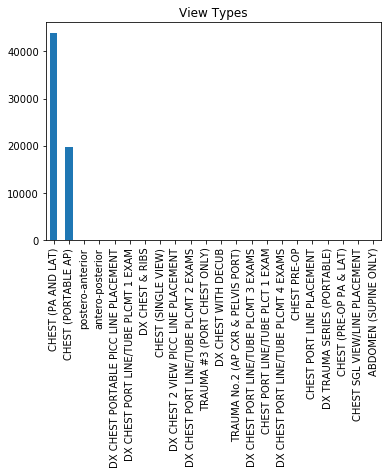

In [21]:
#Get view types
d_mimic.csv['ProcedureCodeSequence_CodeMeaning'].unique()
d_views = d_mimic.csv['ProcedureCodeSequence_CodeMeaning']

#Get the count of appearences of each view
views_counts = d_views.value_counts()

#Plot
views_counts_plot = views_counts.plot(kind="bar")
views_counts_plot.set_title("View Types")

In [23]:
allowed_pa_views = {'CHEST (PA AND LAT)'}
allowed_ap_views = {'CHEST (PORTABLE AP)',  'CHEST (SINGLE VIEW)'}
d_classes_mimic = d_mimic.csv[['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'ProcedureCodeSequence_CodeMeaning']].copy()

d_classes_mimic = d_classes_mimic.clip(lower=0)
exclusive_filter = d_classes_mimic.sum(axis=1)

#Filter out unwatned view types
d_class_cnt = d_classes_mimic[d_classes_mimic['ProcedureCodeSequence_CodeMeaning'].isin(allowed_ap_views)]
d_ex_cnt = d_class_cnt[exclusive_filter == 1]


d_pnu_cnt = d_ex_cnt[d_ex_cnt['Pneumonia'] == 1.0]
d_card_cnt = d_ex_cnt[d_ex_cnt['Cardiomegaly'] == 1.0]
d_nf_cnt = d_ex_cnt[d_ex_cnt['No Finding'] == 1.0]
d_effusion_cnt = d_ex_cnt[d_ex_cnt['Pleural Effusion'] == 1.0]

print("Lone AP")
print(d_pnu_cnt['Pneumonia'].count())
print(d_card_cnt['Cardiomegaly'].count())
print(d_nf_cnt['No Finding'].count())
print(d_effusion_cnt['Pleural Effusion'].count())


Lone AP
174
789
11139
365


In [24]:

d_class_cnt = d_classes_mimic[d_classes_mimic['ProcedureCodeSequence_CodeMeaning'].isin(allowed_pa_views)]

d_ex_cnt = d_class_cnt[exclusive_filter == 1]

d_pnu_cnt = d_ex_cnt[d_ex_cnt['Pneumonia'] == 1.0]
d_card_cnt = d_ex_cnt[d_ex_cnt['Cardiomegaly'] == 1.0]
d_nf_cnt = d_ex_cnt[d_ex_cnt['No Finding'] == 1.0]
d_effusion_cnt = d_ex_cnt[d_ex_cnt['Pleural Effusion'] == 1.0]


print("Lone PA")
print(d_pnu_cnt['Pneumonia'].count())
print(d_card_cnt['Cardiomegaly'].count())
print(d_nf_cnt['No Finding'].count())
print(d_effusion_cnt['Pleural Effusion'].count())

Lone PA
612
1116
31643
444


In [25]:

d_classes_mimic = pd.concat([d_mimic.csv['Cardiomegaly'], d_mimic.csv['No Finding'], d_mimic.csv['Pneumonia'], d_mimic.csv['ProcedureCodeSequence_CodeMeaning']], axis=1)
d_class_cnt_ap = d_classes_mimic[d_classes_mimic['ProcedureCodeSequence_CodeMeaning'].isin(allowed_ap_views)]
d_class_cnt_pa = d_classes_mimic[d_classes_mimic['ProcedureCodeSequence_CodeMeaning'].isin(allowed_pa_views)]
exclusive_filter_ap = d_class_cnt_ap.sum(axis=1)
exclusive_filter_pa = d_class_cnt_pa.sum(axis=1)


d_ex_cnt_ap = d_class_cnt_ap[exclusive_filter_ap == 1]
d_ex_cnt_pa = d_class_cnt_pa[exclusive_filter_pa == 1]


d_pnu_cnt_ap = d_ex_cnt_ap[d_ex_cnt_ap['Pneumonia'] == 1.0]
d_card_cnt_ap = d_ex_cnt_ap[d_ex_cnt_ap['Cardiomegaly'] == 1.0]
d_nf_cnt_ap = d_ex_cnt_ap[d_ex_cnt_ap['No Finding'] == 1.0]


d_pnu_cnt_pa = d_ex_cnt_pa[d_ex_cnt_pa['Pneumonia'] == 1.0]
d_card_cnt_pa = d_ex_cnt_pa[d_ex_cnt_pa['Cardiomegaly'] == 1.0]
d_nf_cnt_pa = d_ex_cnt_pa[d_ex_cnt_pa['No Finding'] == 1.0]


print("AP")
print(d_pnu_cnt_ap.count())
print(d_card_cnt_ap.count())
print(d_nf_cnt_ap.count())
print("PA")
print(d_pnu_cnt_pa.count())
print(d_card_cnt_pa.count())
print(d_nf_cnt_pa.count())




AP
Cardiomegaly                         214
No Finding                             0
Pneumonia                            606
ProcedureCodeSequence_CodeMeaning    606
dtype: int64
Cardiomegaly                         2426
No Finding                              0
Pneumonia                            1015
ProcedureCodeSequence_CodeMeaning    2426
dtype: int64
Cardiomegaly                         11139
No Finding                           11139
Pneumonia                            11139
ProcedureCodeSequence_CodeMeaning    11139
dtype: int64
PA
Cardiomegaly                          204
No Finding                              0
Pneumonia                            1442
ProcedureCodeSequence_CodeMeaning    1442
dtype: int64
Cardiomegaly                         2272
No Finding                              0
Pneumonia                             822
ProcedureCodeSequence_CodeMeaning    2272
dtype: int64
Cardiomegaly                         31643
No Finding                           31643
Pne

Text(0.5, 1.0, 'Count of each label (any appearance)')

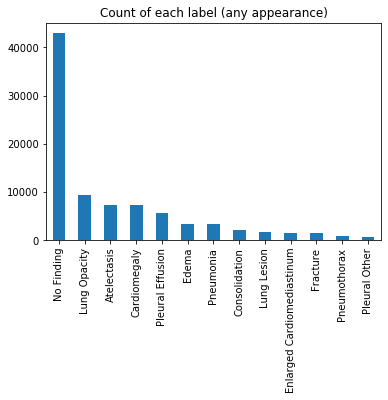

In [26]:
#Seperate columns with labelling
d_labels = pd.concat([d_mimic.csv['Atelectasis'], d_mimic.csv['Cardiomegaly'],
       d_mimic.csv['Consolidation'], d_mimic.csv['Edema'], d_mimic.csv['Enlarged Cardiomediastinum'], d_mimic.csv['Fracture'],
       d_mimic.csv['Lung Lesion'], d_mimic.csv['Lung Opacity'], d_mimic.csv['No Finding'], d_mimic.csv['Pleural Effusion'],
       d_mimic.csv['Pleural Other'], d_mimic.csv['Pneumonia'], d_mimic.csv['Pneumothorax']], axis=1)

#Get counts of each collumns with rows that equal 1
label_counts = d_labels.eq(1).sum(axis=0)
label_counts = label_counts.sort_values(ascending=False)

#Drop no findings
label_counts_dropped = label_counts.drop('No Finding')


label_plot = label_counts.plot(kind = "bar")
label_plot.set_title("Count of each label (any appearance)")



Text(0.5, 1.0, 'Count of each label (No findings ommitted)')

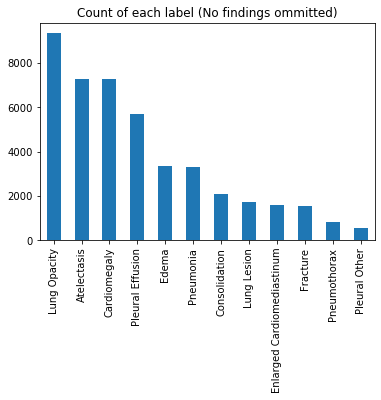

In [27]:
label_plot_2 = label_counts_dropped.plot(kind = "bar")
label_plot_2.set_title("Count of each label (No findings ommitted)")

In [28]:
#Get label counts for individual appearences (everything else is 0)
#View is set to allowed AP views
d_labels = d_labels.clip_lower(0)
filter = d_labels.sum(axis=1)

d_labels_ap = d_labels[d_mimic.csv['ProcedureCodeSequence_CodeMeaning'].isin(allowed_ap_views)]
d_labels_pa = d_labels[d_mimic.csv['ProcedureCodeSequence_CodeMeaning'].isin(allowed_pa_views)]


d_labels_ap = d_labels_ap[filter <= 1]
d_labels_pa = d_labels_pa[filter <= 1]
singleSums_ap = d_labels_ap.sum(axis=0)
singleSums_pa = d_labels_pa.sum(axis=0)


Text(0.5, 1.0, 'Count of each label (Mutually Exclusive)')

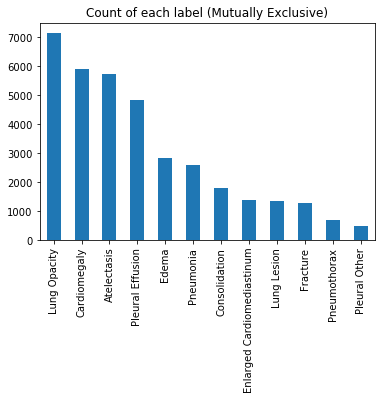

In [29]:
#Filter out all collumns where everything = 0
label_counts_ex = d_labels.eq(1)

#Filter out rows where there are 2 collumns with 1's 
label_counts_ex = label_counts_ex[~(label_counts_ex.sum(axis=1) == 2)]

#Sum remaining rows per column
label_counts_ex = label_counts_ex.sum(axis=0)
label_counts_ex = label_counts_ex.drop('No Finding')
label_counts_ex = label_counts_ex.sort_values(ascending=False)
label_counts_ex_plot = label_counts_ex.plot(kind="bar")
label_counts_ex_plot.set_title("Count of each label (Mutually Exclusive)")
#df = df[~(df.sum(axis=1) == 2)]